# Term1 Sprint アンサンブル学習　


In [1]:
#基本ライブラリ
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
#scikit-learnライブラリ
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

#データセット
#from sklearn.datasets import load_iris

In [32]:
#今回用
from tqdm import tqdm_notebook as tqdm
import time

### データセット

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

この中のtrain.csvをダウンロードし、目的変数としてSalePrice、説明変数として、GrLivAreaとYearBuiltを使う。

In [3]:
df_0 = pd.read_csv('../HousePrice_train.csv', index_col=0)
df_0.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df = df_0.loc[:, ["GrLivArea","YearBuilt","SalePrice"]]
df.head()

,GrLivArea,YearBuilt,SalePrice
Id,,,
1,1710,2003,208500
2,1262,1976,181500
3,1786,2001,223500
4,1717,1915,140000
5,2198,2000,250000


In [309]:
#分割
X = df.iloc[:,[0,1]].values
y = df["SalePrice"].values

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=5,) #シードも設定しておく

print("X_train", np.shape(X_train))
print("X_test", np.shape(X_test))
print("Y_train", np.shape(y_train))
print("Y_test", np.shape(y_test))

X_train (1168, 2)
X_test (292, 2)
Y_train (1168,)
Y_test (292,)


## 【問題１】ブレンディングのスクラッチ実装

### ノーマルスコア

In [253]:
#線形回帰モデル
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)

print(metrics.mean_squared_error(y_test, y_pred))

1791178375.2870069


### ブレンド関数

In [86]:
def model_blending(X_train, y_train, x_test, *args):
    """
    ブレンディングを実行する関数
    
    ----
    *args：任意数のモデルをインスタンス化した状態で渡す
    """
    y_pred = np.empty((x_test.shape[0],1))
    
    for model in args:
        clf = model.fit(X_train, y_train)
        y_pred = np.concatenate([y_pred, clf.predict(x_test).reshape(-1,1)], 1)
    
    y_pred = y_pred[:, 1:]
    
    return y_pred.mean(axis=1)

### ブレンド１

In [31]:
#LinearRegression + SVR
from sklearn.svm import SVR
svr1 = SVR(kernel="linear", C=5, epsilon=0.5)   #パラメータは適当

y_pred2 = model_blending(X_train, y_train, X_test, LinearRegression(), svr1 )

print(metrics.mean_squared_error(y_test, y_pred2))

1879793616.127132


MSEがむしろ上がってしまったので、SVRのパラメーターをグリッドサーチで最適化してみる

In [37]:
from sklearn.model_selection import GridSearchCV

params_cnt = 5
params = {"C": np.logspace(0, 1, params_cnt), "epsilon":np.logspace(-1, 1, params_cnt)}
gridsearch = GridSearchCV(SVR(kernel="linear"), params, cv=5, scoring="r2", return_train_score=True)

for _ in tqdm(range(100)):
    gridsearch.fit(X_train, y_train)


In [38]:
print('Best parameters: {}'.format(gridsearch.best_params_))
print('Best cross-validation: {}'.format(gridsearch.best_score_))

Best parameters: {'C': 10.0, 'epsilon': 0.1}
Best cross-validation: 0.6101533758499665


### ブレンド２

In [39]:
svr2 = SVR(kernel="linear", C=10, epsilon=0.1)  

y_pred3 = model_blending(X_train, y_train, X_test, LinearRegression(), svr2 )

print(metrics.mean_squared_error(y_test, y_pred3))

1879153606.0976024


少し下がったが、まだ最初より高い

### ブレンド３


In [87]:
#線形回帰＋決定木
from sklearn.tree import DecisionTreeRegressor

y_pred4 = model_blending(X_train, y_train, X_test, LinearRegression(), DecisionTreeClassifier() )

print(metrics.mean_squared_error(y_test, y_pred4))

1826201953.024476


In [71]:
#線形回帰＋ランダムフォレスト
from sklearn.ensemble import RandomForestRegressor

y_pred5 = model_blending(X_train, y_train, X_test, LinearRegression(), RandomForestRegressor() )

print(metrics.mean_squared_error(y_test, y_pred5))

1433153261.2902632


だいぶスコアが良くなった！
ブレンドはモデルに左右される部分が大きそう。

### ブレンド関数（改）

モデルごとに重み付けができるように関数を改良する

In [88]:
def model_blending(X_train, y_train, x_test, bias, *args):
    """
    ブレンディングを実行する関数
    
    ----
    bias：モデルの重みを足してモデル数になるようにリストで渡す　例：[1.2, 0.8]
    *args：任意数のモデルをインスタンス化した状態で渡す
    """
    if bias is None:
        bias_val = np.ones(len(args))
    else:
        bias_val = bias
    
    y_pred = np.empty((x_test.shape[0],1))
    
    for model in args:
        clf = model.fit(X_train, y_train)
        y_pred = np.concatenate([y_pred, clf.predict(x_test).reshape(-1,1)], 1)
    
    y_pred = y_pred[:, 1:]
    
    for i in range(len(bias)):
        y_pred[:, i] * bias_val[i]
    
    return y_pred.mean(axis=1)

### ブレンド４

In [74]:
y_pred6 = model_blending(X_train, y_train, X_test, [0.8, 1.2], LinearRegression(), RandomForestRegressor() )

print(metrics.mean_squared_error(y_test, y_pred6))

1424498166.0505464


ランダムフォレストの重みを増やしたことで、さらにMSEが下がった！

### ブレンド５

In [75]:
#線形回帰＋ランダムフォレスト回帰＋SVR
y_pred7 = model_blending(X_train, y_train, X_test, [1, 1.3, 0.7], 
                         LinearRegression(), RandomForestRegressor(), DecisionTreeClassifier() )

print(metrics.mean_squared_error(y_test, y_pred7))

1638163885.9933097


In [76]:
#ランダムフォレストをグリッドサーチしてみる

params_cnt = 5
params = {"n_estimators": [3, 10, 100, 1000]}
gridsearch = GridSearchCV(RandomForestRegressor(), params, cv=5, scoring="r2", return_train_score=True)

for _ in tqdm(range(100)):
    gridsearch.fit(X_train, y_train)



In [79]:
print('Best parameters: {}'.format(gridsearch.best_params_))
print('Best cross-validation: {}'.format(gridsearch.best_score_))

Best parameters: {'n_estimators': 100}
Best cross-validation: 0.6662649481197642


In [80]:
#線形回帰＋ランダムフォレスト回帰＋SVR
y_pred8 = model_blending(X_train, y_train, X_test, [0.8, 1.2], 
                         LinearRegression(), RandomForestRegressor(n_estimators=100))

print(metrics.mean_squared_error(y_test, y_pred8))

1388878710.524175


最終的にかなりMSEが下がった！

## 【問題２】バギングのスクラッチ実装

**＜バギングとは＞**
バギングは入力データの選び方を多様化する方法。学習データから重複を許した上でランダムに抜き出すことで、N種類のサブセット（ ブートストラップサンプル ）を作り出す。それらによってモデルをN個学習し、推定結果の平均をとる。ブレンディングと異なり、それぞれの重み付けを変えることはない。

scikit-learnのtrain_test_splitを、shuffleパラメータをTrueにして使うことで、ランダムにデータを分割することができる。これによりブートストラップサンプルが手に入る。推定結果の平均をとる部分はブースティングと同様の実装になる。

In [89]:
#回帰木でのノーマル結果
from sklearn.tree import DecisionTreeRegressor

DTR = DecisionTreeRegressor()
DTR.fit(X_train, y_train)
y_pred = DTR.predict(X_test)

print(metrics.mean_squared_error(y_test, y_pred))

2835391289.0536532


In [90]:
def Bagging(X, y, X_test, model, cnt=2, split=0.2):
    """
    バギングを行う関数
    
    ----
    X: スプリット前のデータ
    y：スプリット前のラベル
    model：インスタンス化したモデル
    cnt：データセットのシャッフルを行う回数
    """
    y_pred = np.empty((X_test.shape[0],1))
    
    for i in range(cnt):
        (X_train_sub, _, y_train_sub, _) = train_test_split(X, y, test_size=split, shuffle=True)            

        model.fit(X_train_sub, y_train_sub)
        y_pred = np.concatenate([y_pred, model.predict(X_test).reshape(-1,1)], 1)
    
    y_pred = y_pred[:, 1:]
    
    return y_pred.mean(axis=1)
              

In [91]:
y_pred_b = Bagging(X_train, y_train, X_test, DecisionTreeRegressor(), cnt=5)

print(metrics.mean_squared_error(y_test, y_pred_b))

1701507594.0470054


バギングを行っただけでかなりMSEが下がってくれた。
これは効果大！

## 【問題３】スタッキングのスクラッチ実装

データの分割（バリデーション）は３として実装する。

In [304]:
def scratch_stacking(X, y, test, model, kfold=3):
    """
    スタッキングの関数
    ----
    model：モデル数×ステージの二次元配列として渡す
    kfold：バリデーションの分割数
    
    """
    stage = len(model)                                #ステージ数取得
    model_num = [len(v) for v in model]     #各ステージごとモデル数取得
    spl_num = X.shape[0]
    f_num = X.shape[1]
    Xy = np.concatenate([X,y.reshape(-1,1)], 1)
    
    """^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    Stage1
    """
    #バリデーション
    shuffled_index = np.random.permutation(np.arange(spl_num))
    shuffled_y = Xy[shuffled_index][:, -1]
    div = 0
    dived_data = {}
    for i in range(kfold):
        if i == kfold-1:
            dived_data[i] = Xy[shuffled_index[div: ]]                                      #最後の分割は端数を含める
        else:
            dived_data[i] = Xy[shuffled_index[div: div+int(spl_num / kfold)]]
            div += int(spl_num / kfold)
    
    #箱初期化
    y_pred_all = np.empty(spl_num)                  #学習フェーズ用
    test_y_pred_all = np.empty(test.shape[0])   #推論フェーズ・最終用
    test_y_pred = np.empty(test.shape[0])       #推論フェーズ・各モデル用
    
    for i in range(model_num[0]):
        m = model[0][i]
        y_pred = np.array([])                              #kごとに予測を足してサンプル数分のyを作る
        print(str(model[0][i])[:3])
        
        for j in range(kfold):
            
            """各KごとにX/y_train, X/y_testの初期化
            """
            X_test = dived_data[j][:, :f_num]
            y_test = dived_data[j][:, -1]
            lest = list(set(dived_data.keys())^set([j]))
            for k, L in enumerate(lest):
                if k == 0:
                    X_train = dived_data[L][:, :f_num]
                    y_train = dived_data[L][:, -1]
                else:
                    X_train = np.vstack((X_train, dived_data[L][:, :f_num]))
                    y_train = np.append(y_train, dived_data[L][:, -1])
            
            """Fit and Predict
            """
            m.fit(X_train, y_train)
            y_pred = np.append(y_pred, m.predict(X_test))
            
            #推論フェーズ用に予測を保存
            test_y_pred = np.vstack((test_y_pred, m.predict(test)))
        
        """予測の整形
        """
        #学習フェーズ
        y_pred_all = np.vstack((y_pred_all, y_pred))
        print("モデル{}のブレンドデータとyのMSE".format(i))
        print(metrics.mean_squared_error(shuffled_y, y_pred))
        print("----------")
        
        #推論フェーズ
        test_y_pred_mean = test_y_pred.T[:, 1:].mean(axis=1)
        test_y_pred_all = np.vstack((test_y_pred_all, test_y_pred_mean))
    
    next_input = y_pred_all.T[:, 1:]
    test_input = test_y_pred_all.T[:, 1:]
    
    """^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    Stage2
    """
    m2 = model[1][0]
    m2.fit(next_input, shuffled_y)
    
    """
    Predict Stage2
    """
    last_pred = m2.predict(test_input)

    
    return last_pred
    

In [305]:
#検証
m_lr = LinearRegression()
m_svr = SVR(kernel="linear", C=10, epsilon=0.1)
m_dtr = DecisionTreeRegressor()
m_rfr = RandomForestRegressor(n_estimators=100)

stackmodel = [
              [m_svr, m_rfr, m_dtr, m_lr],   #Stage1
              [m_lr]]                      #Stage2

final_pred = scratch_stacking(X_train, y_train, X_test, stackmodel)

SVR
モデル0のブレンドデータとyのMSE
5832144278.490742
----------
Ran
モデル1のブレンドデータとyのMSE
2041963805.4805775
----------
Dec
モデル2のブレンドデータとyのMSE
3228049330.1617675
----------
Lin
モデル3のブレンドデータとyのMSE
2315542431.8034
----------


In [300]:
print(metrics.mean_squared_error(y_test, final_pred))

1552098550.2119095


### 比較結果（K=3、非正規化）
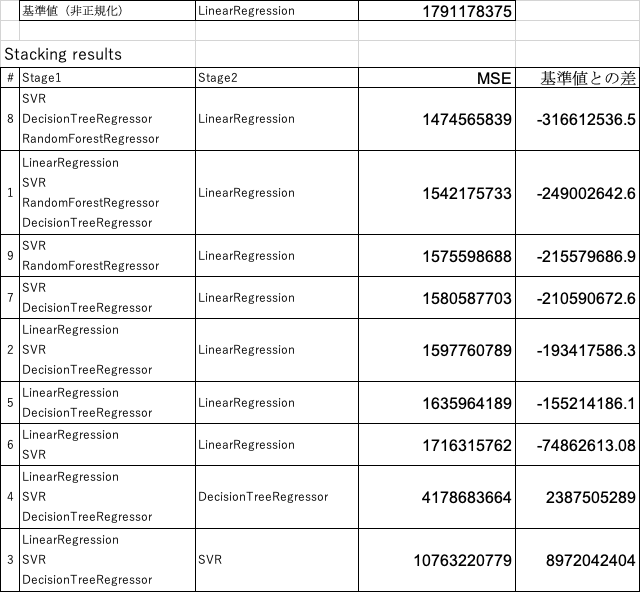

### 関数の改良（Stage3対応）

In [306]:
class Multi_Stacking():
    
    def __init__(self, ):
        # ハイパーパラメータを属性として記録
        self.internal_score_ = []

    def fit_predict(self, X, y, test, model, k_num): 
        stage = len(model)    #ステージ数取得
        
        Xs = X
        ys = y
        tests = test
        for i in range(2):
            Xs, ys, tests = self.stacking(Xs, ys, tests, model[i], kfold=k_num[i])
        
        m3 = model[2][0]
        m3.fit(Xs, ys)
        
        last_pred = m3.predict(tests)
        
        return last_pred
        
        
    def stacking(self, X, y, test, model, kfold=3):
        """
        スタッキングの関数
        ----
        model：モデル数×ステージの二次元配列として渡す
        kfold：バリデーションの分割数

        """
        model_num = len(model)     #各ステージごとモデル数取得
        spl_num = X.shape[0]
        f_num = X.shape[1]
        Xy = np.concatenate([X,y.reshape(-1,1)], 1)

        """^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        Stage1
        """
        #バリデーション
        shuffled_index = np.random.permutation(np.arange(spl_num))
        shuffled_y = Xy[shuffled_index][:, -1]
        div = 0
        dived_data = {}
        for i in range(kfold):
            if i == kfold-1:
                dived_data[i] = Xy[shuffled_index[div: ]]                                      #最後の分割は端数を含める
            else:
                dived_data[i] = Xy[shuffled_index[div: div+int(spl_num / kfold)]]
                div += int(spl_num / kfold)

        #箱初期化
        y_pred_all = np.empty(spl_num)                  #学習フェーズ用
        test_y_pred_all = np.empty(test.shape[0])   #推論フェーズ・最終用
        test_y_pred = np.empty(test.shape[0])       #推論フェーズ・各モデル用

        for i in range(model_num):
            m = model[i]
            y_pred = np.array([])                              #kごとに予測を足してサンプル数分のyを作る

            for j in range(kfold):

                """各KごとにX/y_train, X/y_testの初期化
                """
                X_test = dived_data[j][:, :f_num]
                y_test = dived_data[j][:, -1]
                lest = list(set(dived_data.keys())^set([j]))
                for k, L in enumerate(lest):
                    if k == 0:
                        X_train = dived_data[L][:, :f_num]
                        y_train = dived_data[L][:, -1]
                    else:
                        X_train = np.vstack((X_train, dived_data[L][:, :f_num]))
                        y_train = np.append(y_train, dived_data[L][:, -1])

                """Fit and Predict
                """
                m.fit(X_train, y_train)
                y_pred = np.append(y_pred, m.predict(X_test))

                #推論フェーズ用に予測を保存
                test_y_pred = np.vstack((test_y_pred, m.predict(test)))

            """予測の整形
            """
            #学習フェーズ
            y_pred_all = np.vstack((y_pred_all, y_pred))
            self.internal_score_.append([str(model[i])[:3], 
                                         metrics.mean_squared_error(shuffled_y, y_pred)])

            #推論フェーズ
            test_y_pred_mean = test_y_pred.T[:, 1:].mean(axis=1)
            test_y_pred_all = np.vstack((test_y_pred_all, test_y_pred_mean))

        next_input = y_pred_all.T[:, 1:]
        test_input = test_y_pred_all.T[:, 1:]

        return next_input, shuffled_y, test_input
    
    

### 3ステージのテスト

- Stage1：線形回帰＋SVR＋回帰木＋ランダムフォレスト　K=4
- Stage2：SVR+回帰木＋ランダムフォレスト　K=3
- Stage3：線形回帰

In [314]:
num_k = [4,3,1]
stackmodel = [
              [m_svr, m_rfr, m_dtr, m_lr],   #Stage1
              [m_rfr, m_dtr, m_svr],                        #Stage2
              [m_lr]]                                  #Stage3                   


ms = Multi_Stacking()
final = ms.fit_predict(X_train, y_train, X_test, stackmodel, num_k)
print(metrics.mean_squared_error(y_test, final))

1818653550.3318226


同じモデルを重ねて利用しているからか、あまり効果は上がらなかった。

以上